In [1]:
import numpy as np
import pandas as pd
import dlib
import cv2
import os
import time
import shutil
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

## Download Dataset

- Dataset download from [link](https://www.dropbox.com/scl/fi/vxoq0s8f69em3jm8n774p/All-Age-Faces-Dataset.zip?dl=0&e=1&rlkey=w1711nofchv38k3qaldt0ybkj)

In [ ]:
# !tar -xf dataset.zip

In [ ]:
# !pip install dlib

All the images are present in the original images dir of dataset dir

## Proof of Concept

(128, 128, 3)


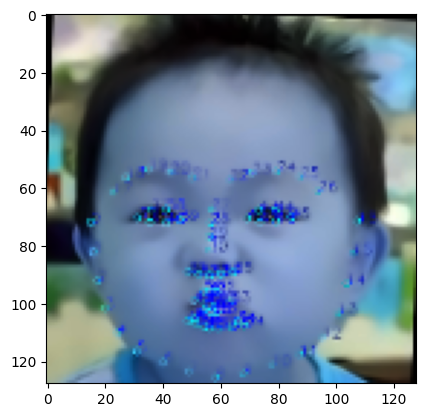

In [3]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(PREDICTOR_PATH)
detector = dlib.get_frontal_face_detector()

def get_landmarks(im):
    rects = detector(im, 1)
    if len(rects) == 0:
        return None
    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def preprocess_image(img, landmarks):
    left_eye_points = [36, 37, 38, 39, 40, 41]
    right_eye_points = [42, 43, 44, 45, 46, 47]

    left_eye_center = np.array([0.0, 0.0])
    right_eye_center = np.array([0.0, 0.0])
    
    for pt in left_eye_points:
        left_eye_center += np.array(landmarks[pt]).flatten()
    left_eye_center /= len(left_eye_points)

    for pt in right_eye_points:
        right_eye_center += np.array(landmarks[pt]).flatten()
    right_eye_center /= len(right_eye_points)

    center = (left_eye_center + right_eye_center) / 2

    slope = (left_eye_center[1] - right_eye_center[1]) / (left_eye_center[0] - right_eye_center[0])
    rot_angle = np.arctan(slope) * 180 / np.pi

    (h, w) = img.shape[:2]

    rotation_matrix = cv2.getRotationMatrix2D(tuple(center), rot_angle, scale=1.0)

    rotated_image = cv2.warpAffine(img, rotation_matrix, (w, h))

    #Denoise the image
    denoised_image = cv2.fastNlMeansDenoisingColored(rotated_image, None, 10, 10, 7, 21)

    cropped_image = denoised_image[0:300, 0:300]

    img = cv2.resize(cropped_image, (128, 128))
    
    return img

    
image = cv2.imread('dataset/example/img.jpg')
landmarks = get_landmarks(image)

image_with_landmarks = annotate_landmarks(image, landmarks)

fig, ax = plt.subplots()
im = ax.imshow(image_with_landmarks)

pre_processed_img = preprocess_image(image_with_landmarks, landmarks)

# img = cv2.resize(pre_processed_img, (110, 110))

print(pre_processed_img.shape)
ax.imshow(pre_processed_img)
plt.show()

In [ ]:
img_df = pd.DataFrame([np.array(img).flatten()])
img_df = pd.concat([img_df, pd.DataFrame(['img.jpg'], columns=['file'])], axis=1)
img_df

## Data Pre-Processing
- Preprocessed files are present in dataset/preprocessed

In [ ]:
def preprocess_dataset(path):
    output_dir = 'dataset/preprocessed'

    if not os.path.exists(output_dir):
        os.mkdir(os.path.join(os.getcwd(), output_dir))

    images_landmarks = []

    left_eye_points = [36, 37, 38, 39, 40, 41]
    right_eye_points = [42, 43, 44, 45, 46, 47]
    
    for file in os.listdir(path):
        img = cv2.imread(path+f'/{file}')
        landmarks = get_landmarks(img)
        if landmarks is None:
            print(f'Face not deteced in {file}')
            continue
        
        images_landmarks.append(landmarks)
        
        left_eye_center = np.array([0.0, 0.0])
        right_eye_center = np.array([0.0, 0.0])
        
        for pt in left_eye_points:
            left_eye_center += np.array(landmarks[pt]).flatten()
        left_eye_center /= len(left_eye_points)
    
        for pt in right_eye_points:
            right_eye_center += np.array(landmarks[pt]).flatten()
        right_eye_center /= len(right_eye_points)
    
        center = (left_eye_center + right_eye_center) / 2
    
        slope = (left_eye_center[1] - right_eye_center[1]) / (left_eye_center[0] - right_eye_center[0])
        rot_angle = np.arctan(slope) * 180 / np.pi
    
        (h, w) = img.shape[:2]
    
        rotation_matrix = cv2.getRotationMatrix2D(tuple(center), rot_angle, scale=1.0)
    
        rotated_image = cv2.warpAffine(img, rotation_matrix, (w, h))
    
        #Denoise the image
        denoised_image = cv2.fastNlMeansDenoisingColored(rotated_image, None, 10, 10, 7, 21)
    
        cropped_image = cv2.resize(denoised_image, (110, 110))

        cv2.imwrite(os.path.join(output_dir, f'{file}'), cropped_image)
        print(f'{file} done!')
    return images_landmarks, output_dir

path = 'dataset/original'
landmarks, preprocessed_path = preprocess_dataset(path)

In [5]:
#Unprocessed files
path = 'dataset/original'
preprocessed_path = 'dataset/preprocessed'
original = os.listdir(path)
preprocessed = os.listdir(preprocessed_path)

unprocessed_files = [file for file in original if file not in preprocessed]

print(f'Number of unprocessed files: {len(unprocessed_files)}, original: {len(original)}')

Number of unprocessed files: 259, original: 13322


In [ ]:
#Save landmarks into .npy file
landmarks_np = np.array(landmarks)

np.save('landmarks.npy', landmarks_np)

In [ ]:
#Constructing a dataframe with pixel values and gender label
#Male - 0, Female - 1

labels_path = 'dataset/image_sets/'

train_df = pd.read_csv(labels_path+'train.txt', sep=' ', header=None, )
train_df = train_df.rename(columns = {0:'File', 1:'Gender_Label'})

val_df = pd.read_csv(labels_path+'val.txt', sep=' ', header=None, )
val_df = val_df.rename(columns = {0:'File', 1:'Gender_Label'}) 

#Dataframe with pixel values and filename
img_df = pd.DataFrame([])

preprocessed_path = 'dataset/preprocessed'

for file in os.listdir(preprocessed_path):
    img = cv2.imread(f'{preprocessed_path}/{file}')
    
    df = pd.DataFrame([np.array(img).flatten()])
    img_df = pd.concat([img_df, pd.concat([df, pd.DataFrame([file], columns=['file'])], axis=1)])

    print(f'{file} done!')

img_df.head()

In [ ]:
dataset_file = 'dataset.csv'
img_df.to_csv(dataset_file)

In [ ]:
img_df = pd.read_csv('dataset.csv')


In [2]:
labels_path = 'dataset/image_sets/'
train_df = pd.read_csv(labels_path+'train.txt', sep=' ', header=None, )
train_df = train_df.rename(columns = {0:'file', 1:'Gender_Label'})

val_df = pd.read_csv(labels_path+'val.txt', sep=' ', header=None, )
val_df = val_df.rename(columns = {0:'file', 1:'Gender_Label'}) 

df = pd.concat([train_df, val_df], axis=0)
# train = pd.concat([train_df.set_index('file'), img_df.set_index('file')], axis=1, join='inner')
# val = pd.concat([val_df.set_index('file'), img_df.set_index('file')], axis=1, join='inner')

In [3]:
preprocessed_path = 'dataset/preprocessed'
preprocessed_list = os.listdir(preprocessed_path)
df_files = df['file']

for file in df_files:
    if file not in preprocessed_list:
        df = df[df['file'] != file]
print(len(df))
df

13063


,file,Gender_Label
0,00000A02.jpg,0
1,00002A02.jpg,0
2,00004A02.jpg,0
3,00006A02.jpg,0
4,00008A02.jpg,0
...,...,...
6680,13312A80.jpg,1
6681,13314A80.jpg,1
6682,13316A80.jpg,1
6683,13318A80.jpg,1


In [4]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=43)
print(len(train_df), len(val_df))

10450 2613


In [46]:
def split_images(image_dir, train_list, val_list, output_dir):
    
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for image_name in train_list:
        src = os.path.join(image_dir, image_name)
        
        dst = os.path.join(train_dir, image_name)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print(f"Warning: {image_name} not found in {image_dir}")

    for image_name in val_list:
        src = os.path.join(image_dir, image_name)
        dst = os.path.join(val_dir, image_name)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print(f"Warning: {image_name} not found in {image_dir}")

    print(f"Images split into {train_dir} and {val_dir}.")

image_dir = "dataset/preprocessed"  
train_list = list(train_df['file'])
val_list = list(val_df['file'])
output_dir = "dataset/split"  

split_images(image_dir, train_list, val_list, output_dir)


Images split into dataset/split\train and dataset/split\val.


In [47]:
train_filenames = set(os.listdir(train_dir))
label_filenames = set(train_df['file'])
missing_in_labels = train_filenames - label_filenames
missing_in_files = label_filenames - train_filenames

print(f"Files in train_dir but missing in train_df: {missing_in_labels}")
print(f"Files in train_df but missing in train_dir: {missing_in_files}")


Files in train_dir but missing in train_df: set()
Files in train_df but missing in train_dir: set()


In [5]:
train_dir = 'dataset/split/train'
val_dir = 'dataset/split/val'

def load_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))  
    img = img / 255.0 
    return img, label

def create_dataset(data_dir, labels):
    file_paths = [data_dir+f'/{fname}' for fname in labels['file']]
    
    valid_file_paths = [path for path in file_paths if os.path.exists(path)]
    
    missing_files = set(file_paths) - set(valid_file_paths)
    if missing_files:
        print(f"Missing files: {missing_files}")

    valid_labels = labels.loc[labels['file'].isin([os.path.basename(p) for p in valid_file_paths]), 'Gender_Label'].values

    if len(valid_file_paths) != len(valid_labels):
        print(f"Mismatch: {len(valid_file_paths)} files and {len(valid_labels)} labels")
        return None  # Return None to indicate an error
    
    dataset = tf.data.Dataset.from_tensor_slices((valid_file_paths, valid_labels))
    dataset = dataset.map(load_image).batch(32).shuffle(buffer_size=1000)
    return dataset

train_dataset = create_dataset(train_dir, train_df)
val_dataset = create_dataset(val_dir, val_df)
print(f'Number of train images: {len(os.listdir(train_dir))}')

Number of train images: 10450


In [6]:
len(train_dataset)

327

## Modelling

### Model-1 (from research paper)

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Input

input_shape = (128, 128, 3)

model = Sequential([
    Input(shape=input_shape),
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),

    Conv2D(filters=320, kernel_size=(3, 3), activation='relu', padding='same'),

    AveragePooling2D(pool_size=(7, 7), strides=1),

    Flatten(),
    Dropout(0.4),
    Dense(2, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 320)           │       1,474,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 2, 2, 320)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,107,042 (38.56 MB)

 Trainable params: 10,107,042 (38.56 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
start_time = time.time()

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time:.2f} seconds.")

Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1300s 4s/step - accuracy: 0.5319 - loss: 0.6969 - val_accuracy: 0.5469 - val_loss: 0.6888
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1284s 4s/step - accuracy: 0.5522 - loss: 0.6885 - val_accuracy: 0.5469 - val_loss: 0.6887
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1294s 4s/step - accuracy: 0.5538 - loss: 0.6876 - val_accuracy: 0.5469 - val_loss: 0.6888
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1275s 4s/step - accuracy: 0.5614 - loss: 0.6856 - val_accuracy: 0.5469 - val_loss: 0.6889
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1250s 4s/step - accuracy: 0.5549 - loss: 0.6873 - val_accuracy: 0.5469 - val_loss: 0.6888
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1254s 4s/step - accuracy: 0.5549 - loss: 0.6874 - val_accuracy: 0.5469 - val_loss: 0.6888
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1260s 4s/step - accuracy: 0.5500 - loss: 0.6884 - val_accuracy: 0.5469 - val_loss: 0.6888
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1248s 4s/step - accuracy: 0.5484 - loss: 0.6886 - 

In [12]:
with open('model', 'wb') as file:
    pickle.dump(model, file)

### Model-2 (finetuning VGG pre-trained)

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16

input_shape = (128, 128, 3)
classes = 2

vgg16 = VGG16(weights='imagenet', input_shape=input_shape, classes=classes, include_top=False)


In [8]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model

for layer in vgg16.layers:
    layer.trainable = False

x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(classes, activation='softmax')(x)

model_vgg = Model(inputs=vgg16.input, outputs=predictions)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
start_time = time.time()

history = model_vgg.fit(train_dataset, epochs=50, validation_data=val_dataset)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time:.2f} seconds.")

Epoch 1/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.6663 - loss: 0.8454 - val_accuracy: 0.8408 - val_loss: 0.3903
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.8027 - loss: 0.4216 - val_accuracy: 0.8511 - val_loss: 0.3640
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.8244 - loss: 0.3793 - val_accuracy: 0.8507 - val_loss: 0.3536
Epoch 4/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.8379 - loss: 0.3644 - val_accuracy: 0.8496 - val_loss: 0.3490
Epoch 5/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.8352 - loss: 0.3597 - val_accuracy: 0.8515 - val_loss: 0.3537
Epoch 6/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.8491 - loss: 0.3426 - val_accuracy: 0.8607 - val_loss: 0.3397
Epoch 7/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.8581 - loss: 0.3167 - val_accuracy: 0.8592 - val_loss: 0.3417
Epoch 8/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.8545 - loss: 0.3212 - val_accu

In [10]:
with open('model_vgg', 'wb') as file:
    pickle.dump(model_vgg, file)

## Testing model

In [2]:
with open('model_vgg', 'rb') as file:
    model_vgg = pickle.load(file)

In [3]:
def preprocess_image(img, landmarks):
    left_eye_points = [36, 37, 38, 39, 40, 41]
    right_eye_points = [42, 43, 44, 45, 46, 47]

    left_eye_center = np.mean([[landmarks.part(pt).x, landmarks.part(pt).y] for pt in left_eye_points], axis=0)
    right_eye_center = np.mean([[landmarks.part(pt).x, landmarks.part(pt).y] for pt in right_eye_points], axis=0)

    slope = (left_eye_center[1] - right_eye_center[1]) / (left_eye_center[0] - right_eye_center[0])
    rot_angle = np.degrees(np.arctan(slope))

    center = tuple(map(float, (left_eye_center + right_eye_center) / 2))  # Ensure standard Python floats

    (h, w) = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D(center, rot_angle, scale=1.0)

    rotated_image = cv2.warpAffine(img, rotation_matrix, (w, h))
    
    cropped_image = rotated_image[0:h, 0:w]  

    denoised_image = cv2.fastNlMeansDenoisingColored(cropped_image, None, 10, 10, 7, 21)

    resized_image = cv2.resize(denoised_image, (128, 128))

    normalized_image = resized_image / 255.0
    
    return np.expand_dims(normalized_image, axis=0)  # Add batch dimension


In [4]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(PREDICTOR_PATH)
detector = dlib.get_frontal_face_detector()

In [5]:
def get_face(frame, landmarks):
    x_coords = [landmarks.part(i).x for i in range(68)]
    y_coords = [landmarks.part(i).y for i in range(68)]
    
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    
    h, w = frame.shape[:2]
    x_min = max(0, x_min)
    x_max = min(w, x_max)
    y_min = max(0, y_min)
    y_max = min(h, y_max)
    
    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    if x_max > x_min and y_max > y_min:
        face_crop = frame[y_min:y_max, x_min:x_max]
        return face_crop
    else:
        return None

def draw_bounding_box_with_text(frame, landmarks, text):
    x_coords = [landmarks.part(i).x for i in range(68)]
    y_coords = [landmarks.part(i).y for i in range(68)]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    
    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    font_scale = 0.5
    font_thickness = 1
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
    text_x = x_min
    text_y = y_min - 10  
    
    text_y = max(10, text_y)
    
    cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        
        img = get_face(frame, landmarks)
        preprocessed_image = preprocess_image(img, landmarks)

        prediction = model_vgg.predict(preprocessed_image)

        text = f"Gender:{'Male' if np.argmax(prediction) else 'Female'}"
        draw_bounding_box_with_text(frame, landmarks, text)
        
    cv2.imshow("Face Detection with Bounding Box", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 